# Tutorial: scRNA-seq data

We show an example of scRNA-seq data produced by 10X Chromium. We are using scRNA-seq data `10k Human PBMCs, 3’ v3.1, Chromium Controller` (11,485 cells and 36,601 genes) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). The test data is directly available from `Feature / cell matrix HDF5 (filtered)` in [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-3-v3-1-chromium-controller-3-1-high) (registration required).

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [1]:
import screcode
import scanpy as sc

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [2]:
input_filename = 'data/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(input_filename)
adata

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

## Apply RECODE
Apply RECODE to the count matrix. The **anndata** or **ndarray** data format is available. 

In [3]:
recode = screcode.RECODE()
adata = recode.fit_transform(adata)

start RECODE for scRNA-seq data


C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 12439, '#non-significant genes': 8969, '#silent genes': 11490, 'ell': 64, 'Elapsed time': '0h 1m 12s 946ms', 'solver': 'randomized', '#test_data': 2297}


With anndata format, outputs of RECODE are included in anndata objects:
- denoised matrix -> adata.obsm['RECODE']
- noise variance -> adata.var['noise_variance_RECODE']
- normalized variance (NVSN variance) ->  adata.var['normalized_variance_RECODE']
- clasification of genes (significant/non-significant/silent) ->  adata.var['significance_RECODE']

In [4]:
adata

AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'noise_variance_RECODE', 'normalized_variance_RECODE', 'significance_RECODE'
    layers: 'RECODE', 'RECODE_ess'

## Performance verification
### Show report:

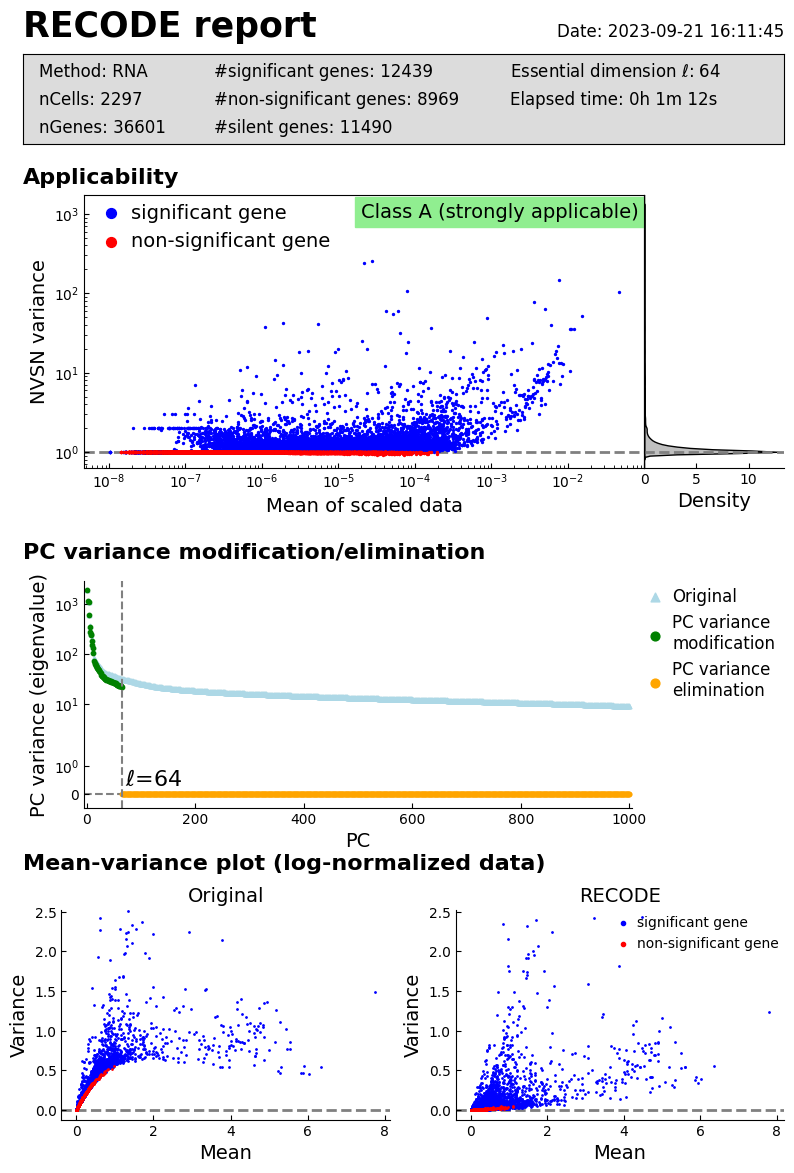

In [5]:
recode.report()

# Downstream analysis based on [scanpy](https://scanpy.readthedocs.io/en/stable/index.html)

In [6]:
import numpy as np
adata.layers["Raw"] = adata.X.toarray()

## log normalization

In [7]:
adata.X = adata.layers["RECODE"]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## PCA

In [8]:
sc.tl.pca(adata, svd_solver='arpack')

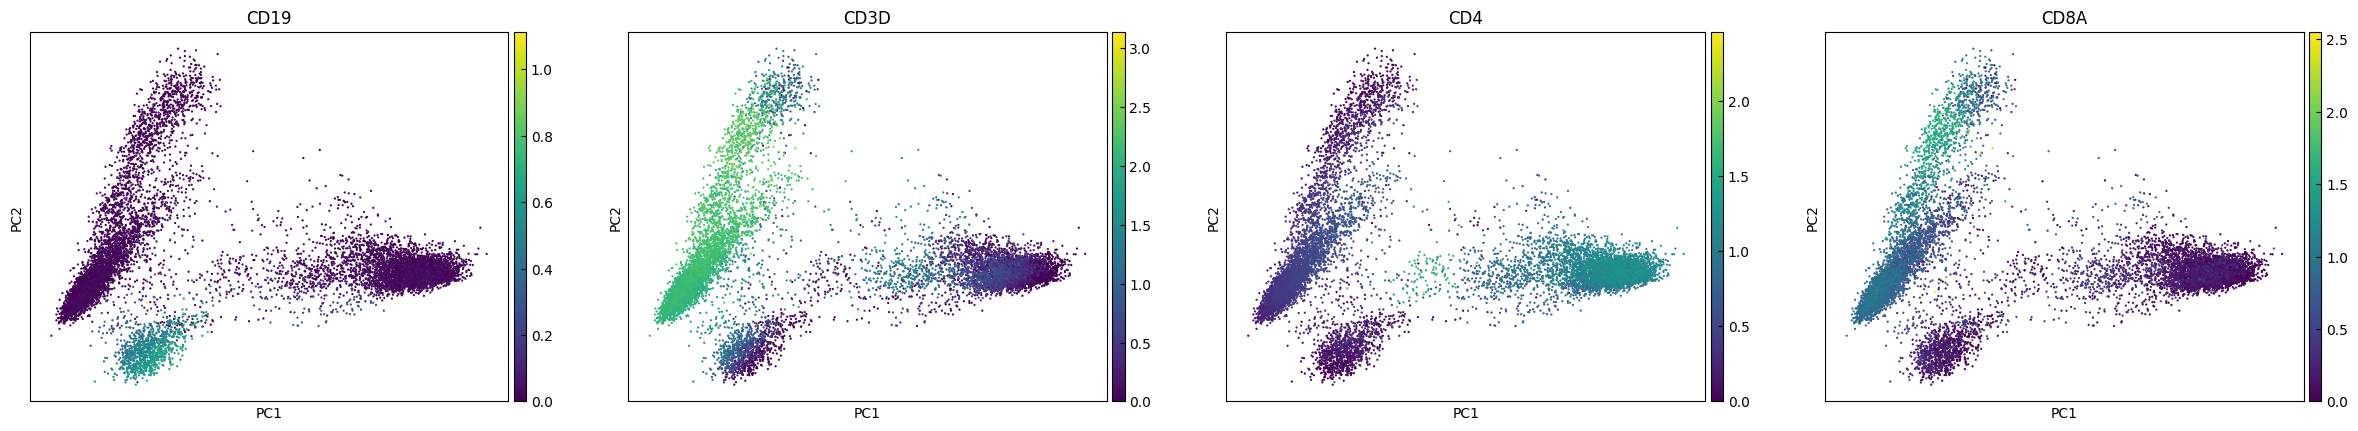

In [9]:
plot_genes = ['CD19','CD3D','CD4','CD8A']
sc.pl.pca(adata, color=plot_genes)

## UMAP

Note that we do not use the PCA dimentionaly reduction as a preprocessing of UMAP (`n_pca=0`). 

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=0)
sc.tl.umap(adata)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecatio

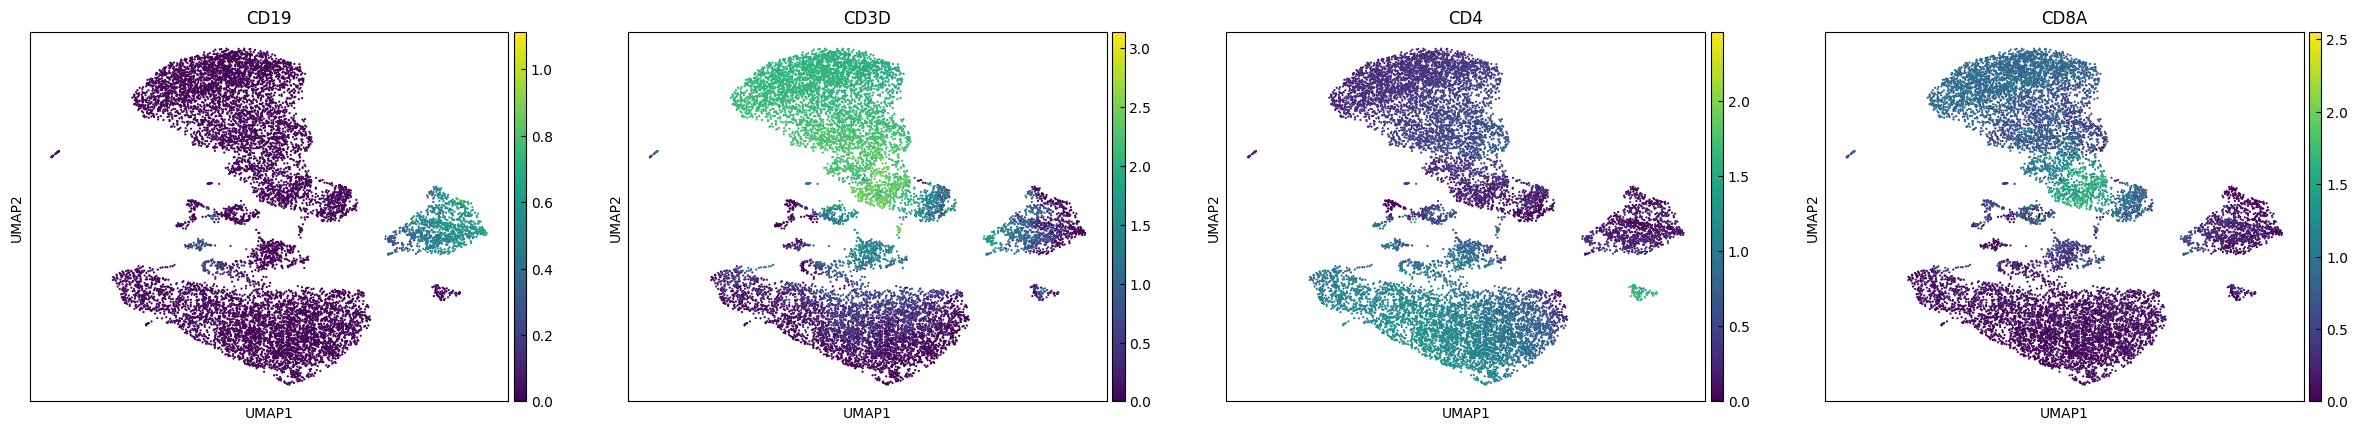

In [11]:
sc.pl.umap(adata, color=plot_genes)

## Clustering

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


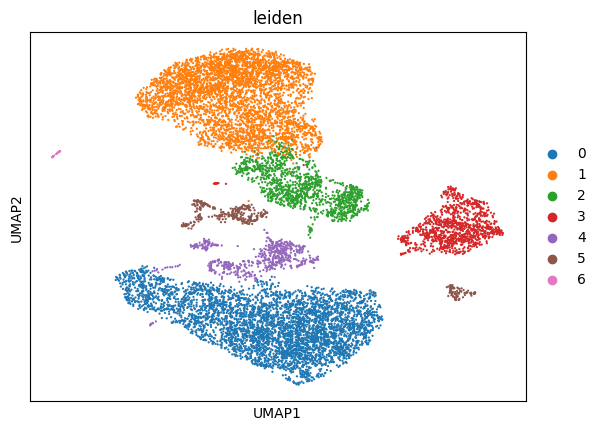

In [12]:
sc.tl.leiden(adata,resolution=0.1)
sc.pl.umap(adata, color=['leiden'])

## Find marker genes

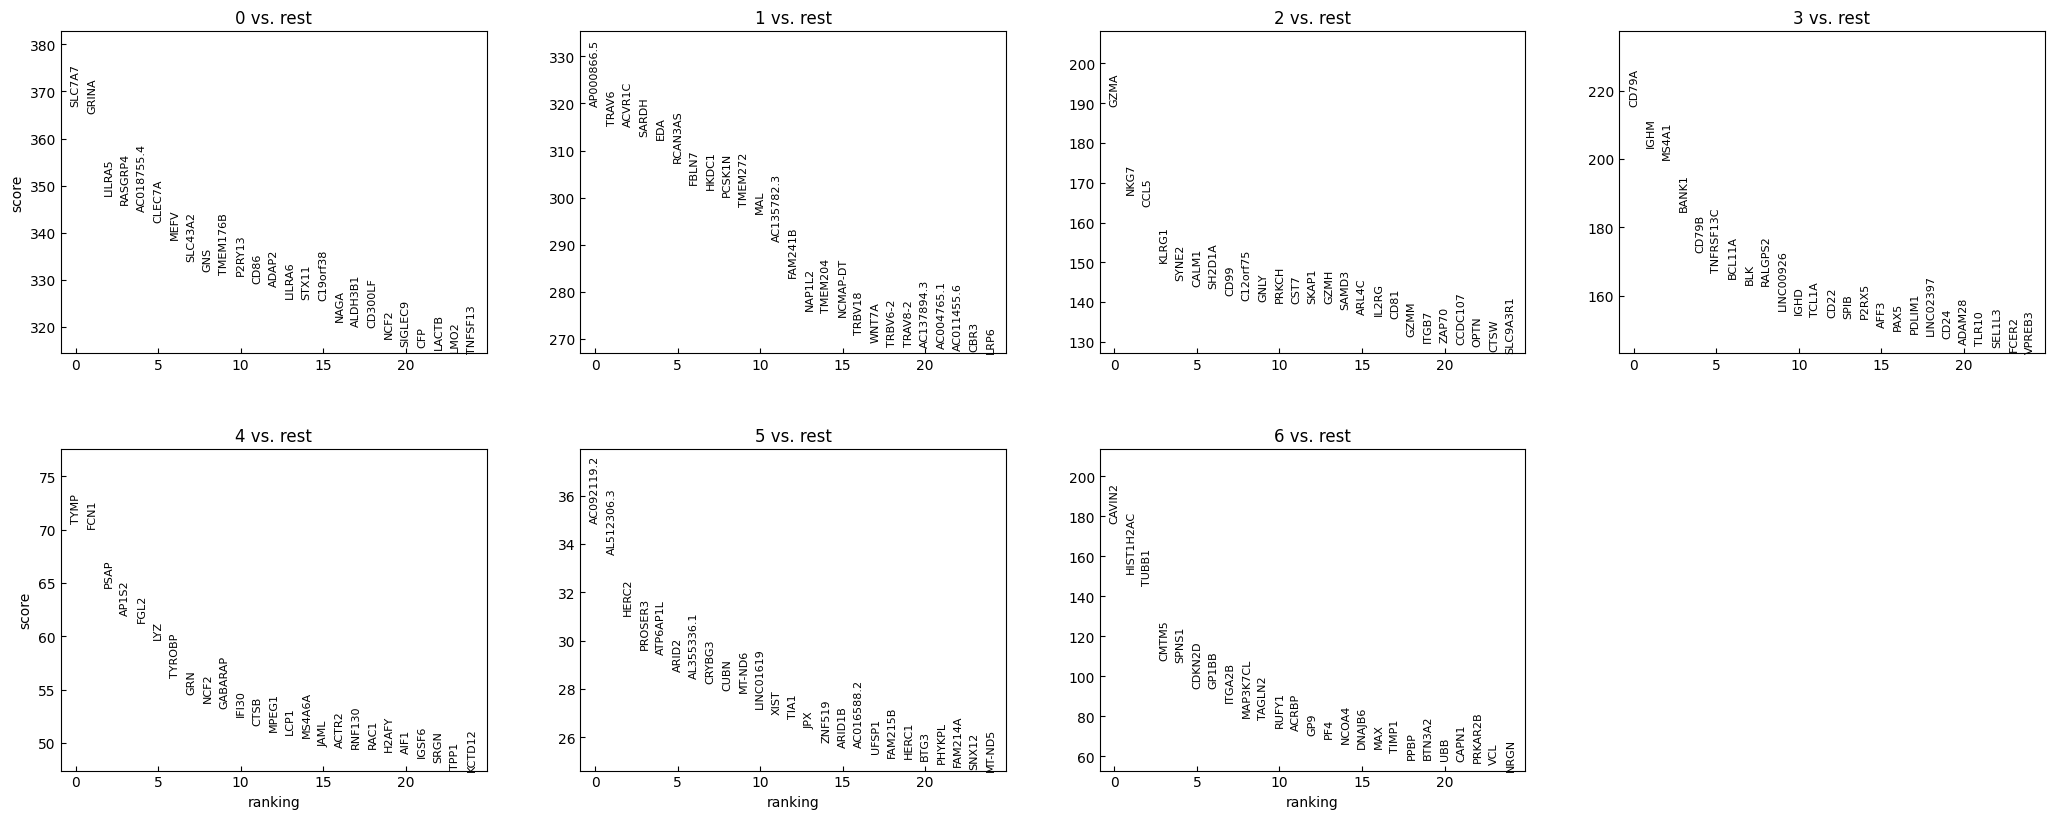

In [13]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [14]:
marker_genes = list(adata.uns['rank_genes_groups']['names'][0]) # The top marker genes for each cluster

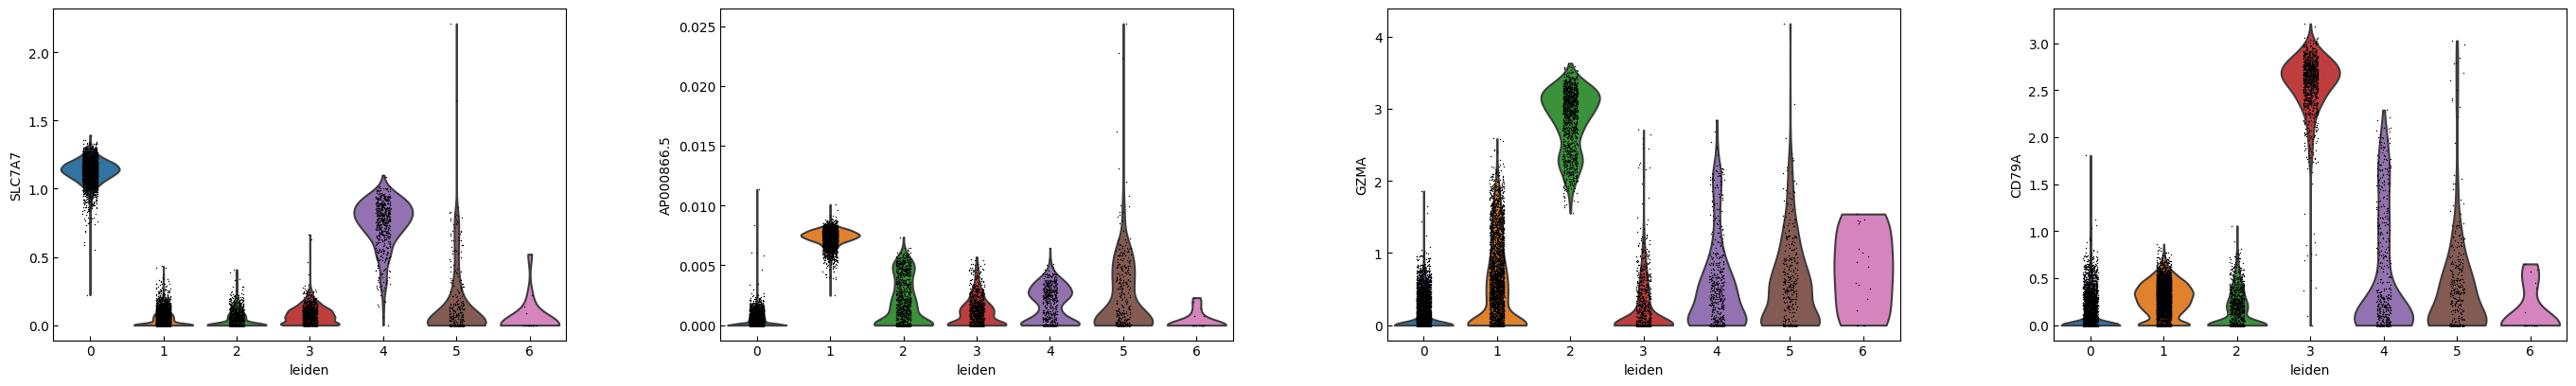

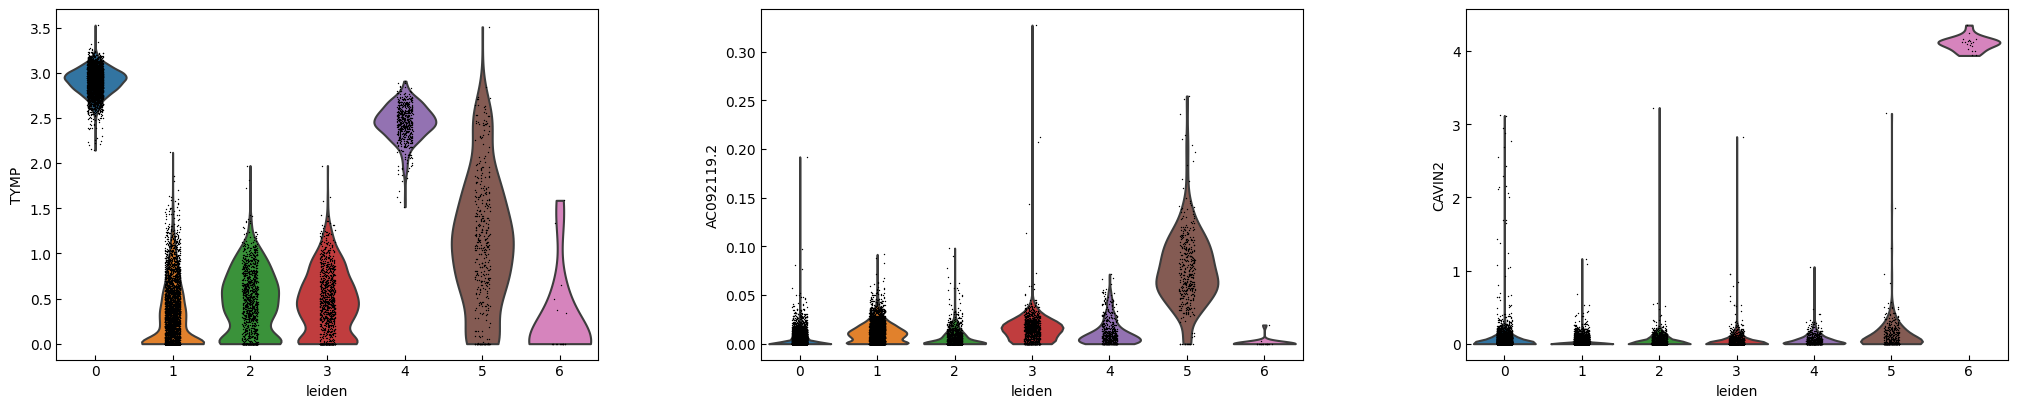

In [15]:
adata.var_names_make_unique()
n_cols = 4
for i in range(0, len(marker_genes),n_cols):
    sc.pl.violin(adata, marker_genes[i:i+n_cols], groupby='leiden')

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


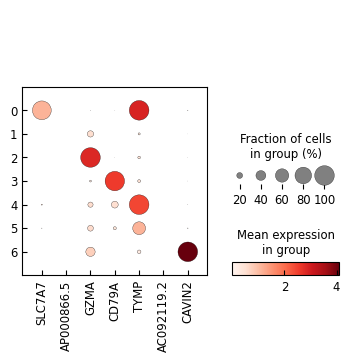

In [16]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden',expression_cutoff=1)

## Gene expression distributions

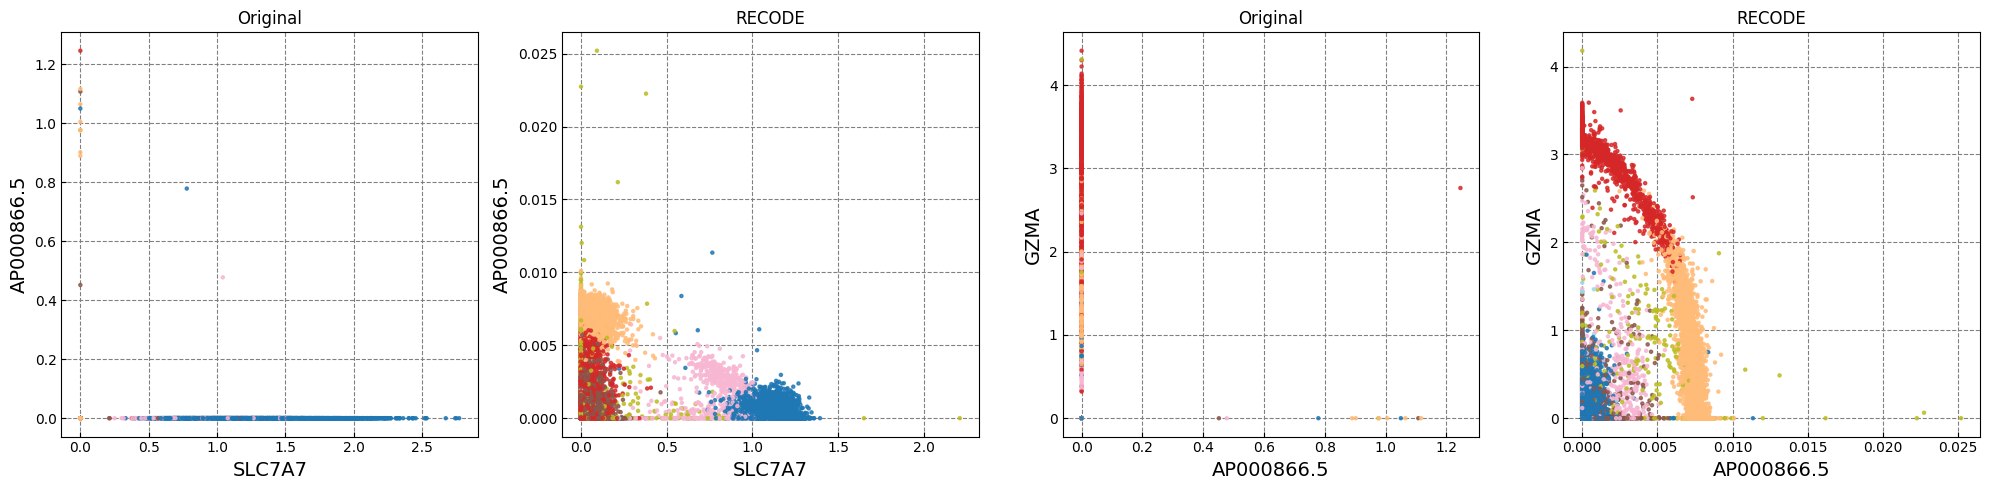

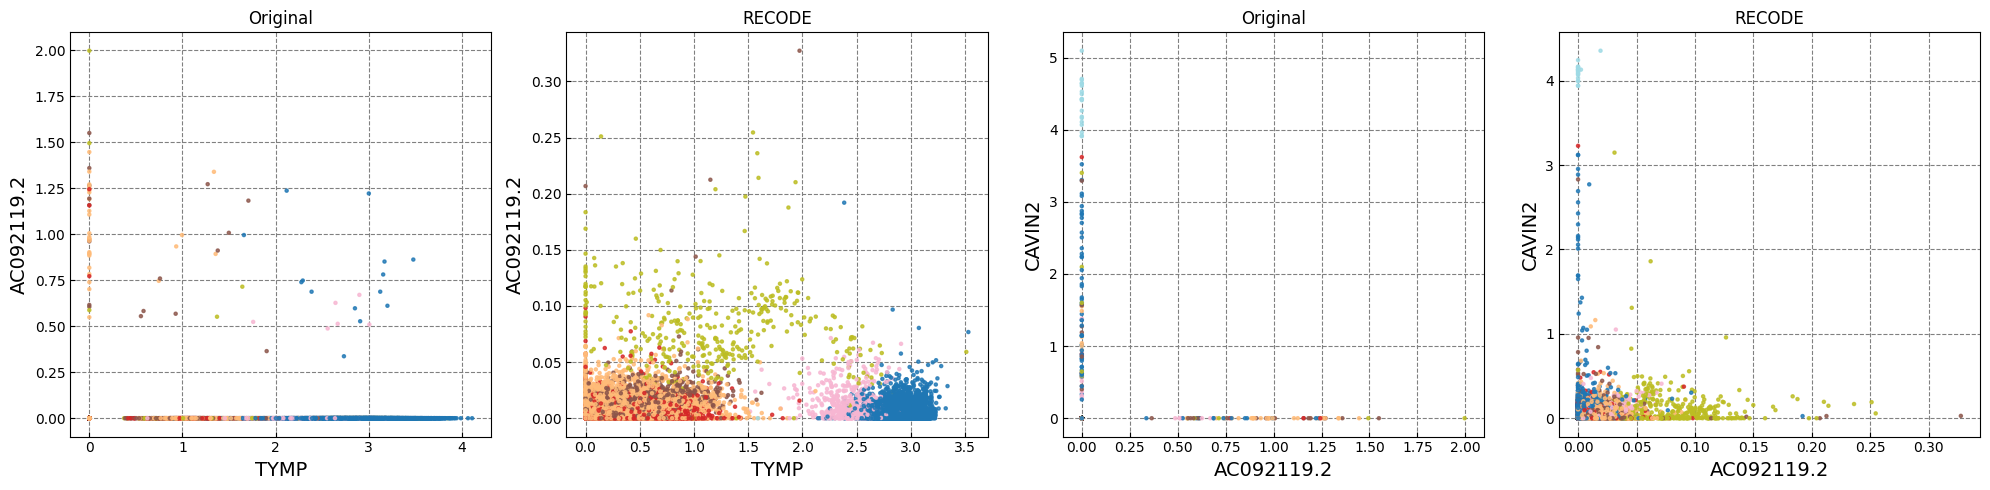

In [17]:
import matplotlib.pyplot as plt


size_factor = 1e4
alpha = 0.8
ps = 5
n_col_genes = 2
fontsize_label = 14
plot_data = [np.log(size_factor*adata.layers['Raw'].T/np.sum(adata.layers['Raw'],axis=1)+1).T,adata.X]
names = ['Original','RECODE']
color = np.array(adata.obs['leiden'].values,dtype=int)

n_plot = len(names)
n_ax =  n_plot * n_col_genes
for k in range(0, len(marker_genes),n_cols):
    fig,ax = plt.subplots(1,n_ax,figsize=(5*n_ax,5),tight_layout=True)
    for i in range(n_plot):
        for j in range(n_col_genes):
            i_ax = n_plot*j+i
            g1_,g2_ = marker_genes[k+j],marker_genes[k+j+1]
            ax[i_ax].scatter(plot_data[i][:,adata.var.index==g1_], plot_data[i][:,adata.var.index==g2_], c=color, alpha=alpha,zorder=10,s=ps,cmap='tab20')
            ax[i_ax].set_xlabel(g1_,fontsize=fontsize_label)
            ax[i_ax].set_ylabel(g2_,fontsize=fontsize_label)
            ax[i_ax].set_title(names[i])
            ax[i_ax].grid(ls='--',color='gray',zorder=0)



# Downstream analysis using essential space of RECODE

In [18]:
import umap
adata_ess = adata.copy()
adata_ess.X = adata.layers["RECODE_ess"]
adata_ess.obsm["X_umap"] = umap.UMAP(n_components=2,n_neighbors=10,random_state=0).fit_transform(adata_ess.X)


In [19]:
sc.pp.neighbors(adata_ess, n_neighbors=10, n_pcs=0)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


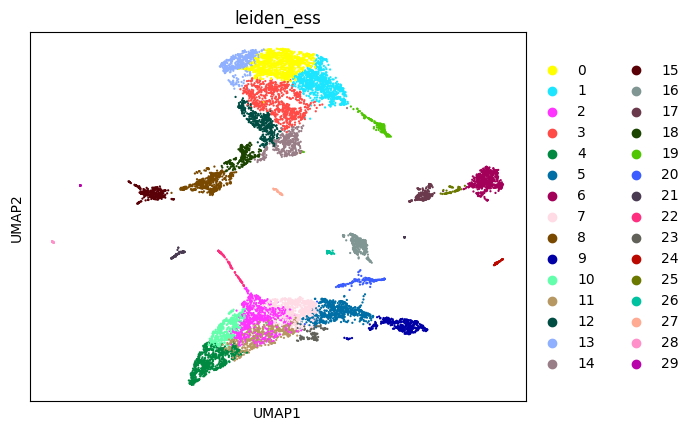

In [ ]:
sc.tl.leiden(adata_ess,key_added='leiden_ess',resolution=0.1)
sc.pl.umap(adata_ess, color=['leiden_ess'])

In [ ]:
adata_ess.obs['leiden'] = adata.obs['leiden']
adata.obs['leiden_ess'] = adata_ess.obs['leiden_ess']

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


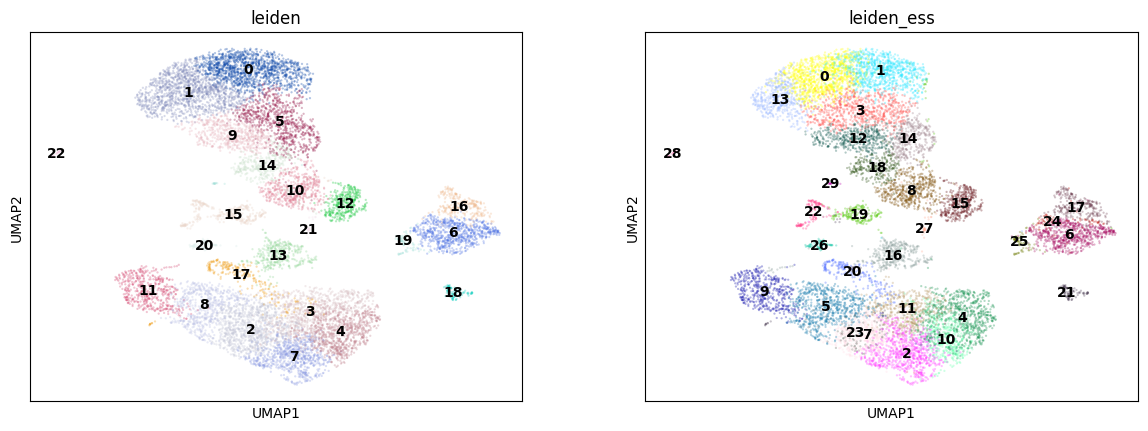

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


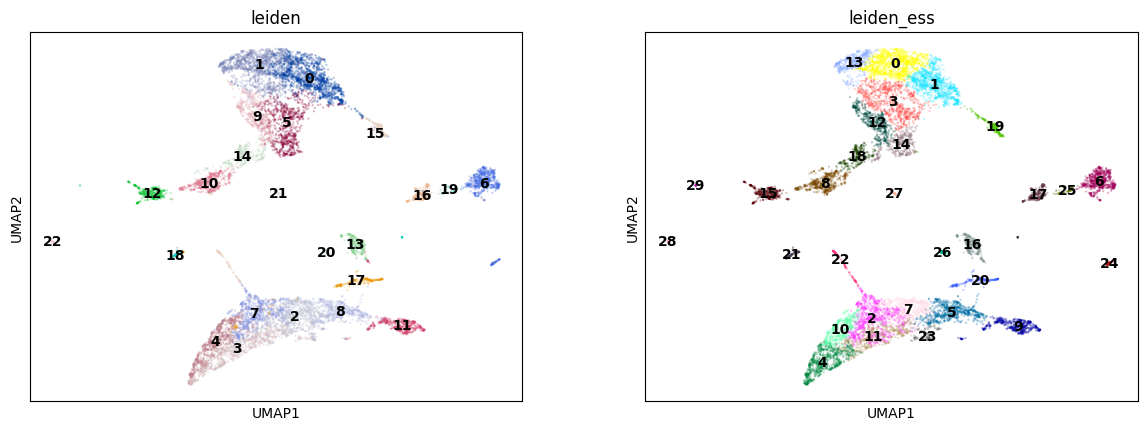

In [ ]:
sc.pl.umap(adata, color=['leiden','leiden_ess'],legend_loc="on data",alpha=0.3)
sc.pl.umap(adata_ess, color=['leiden','leiden_ess'],legend_loc="on data",alpha=0.3)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\tools

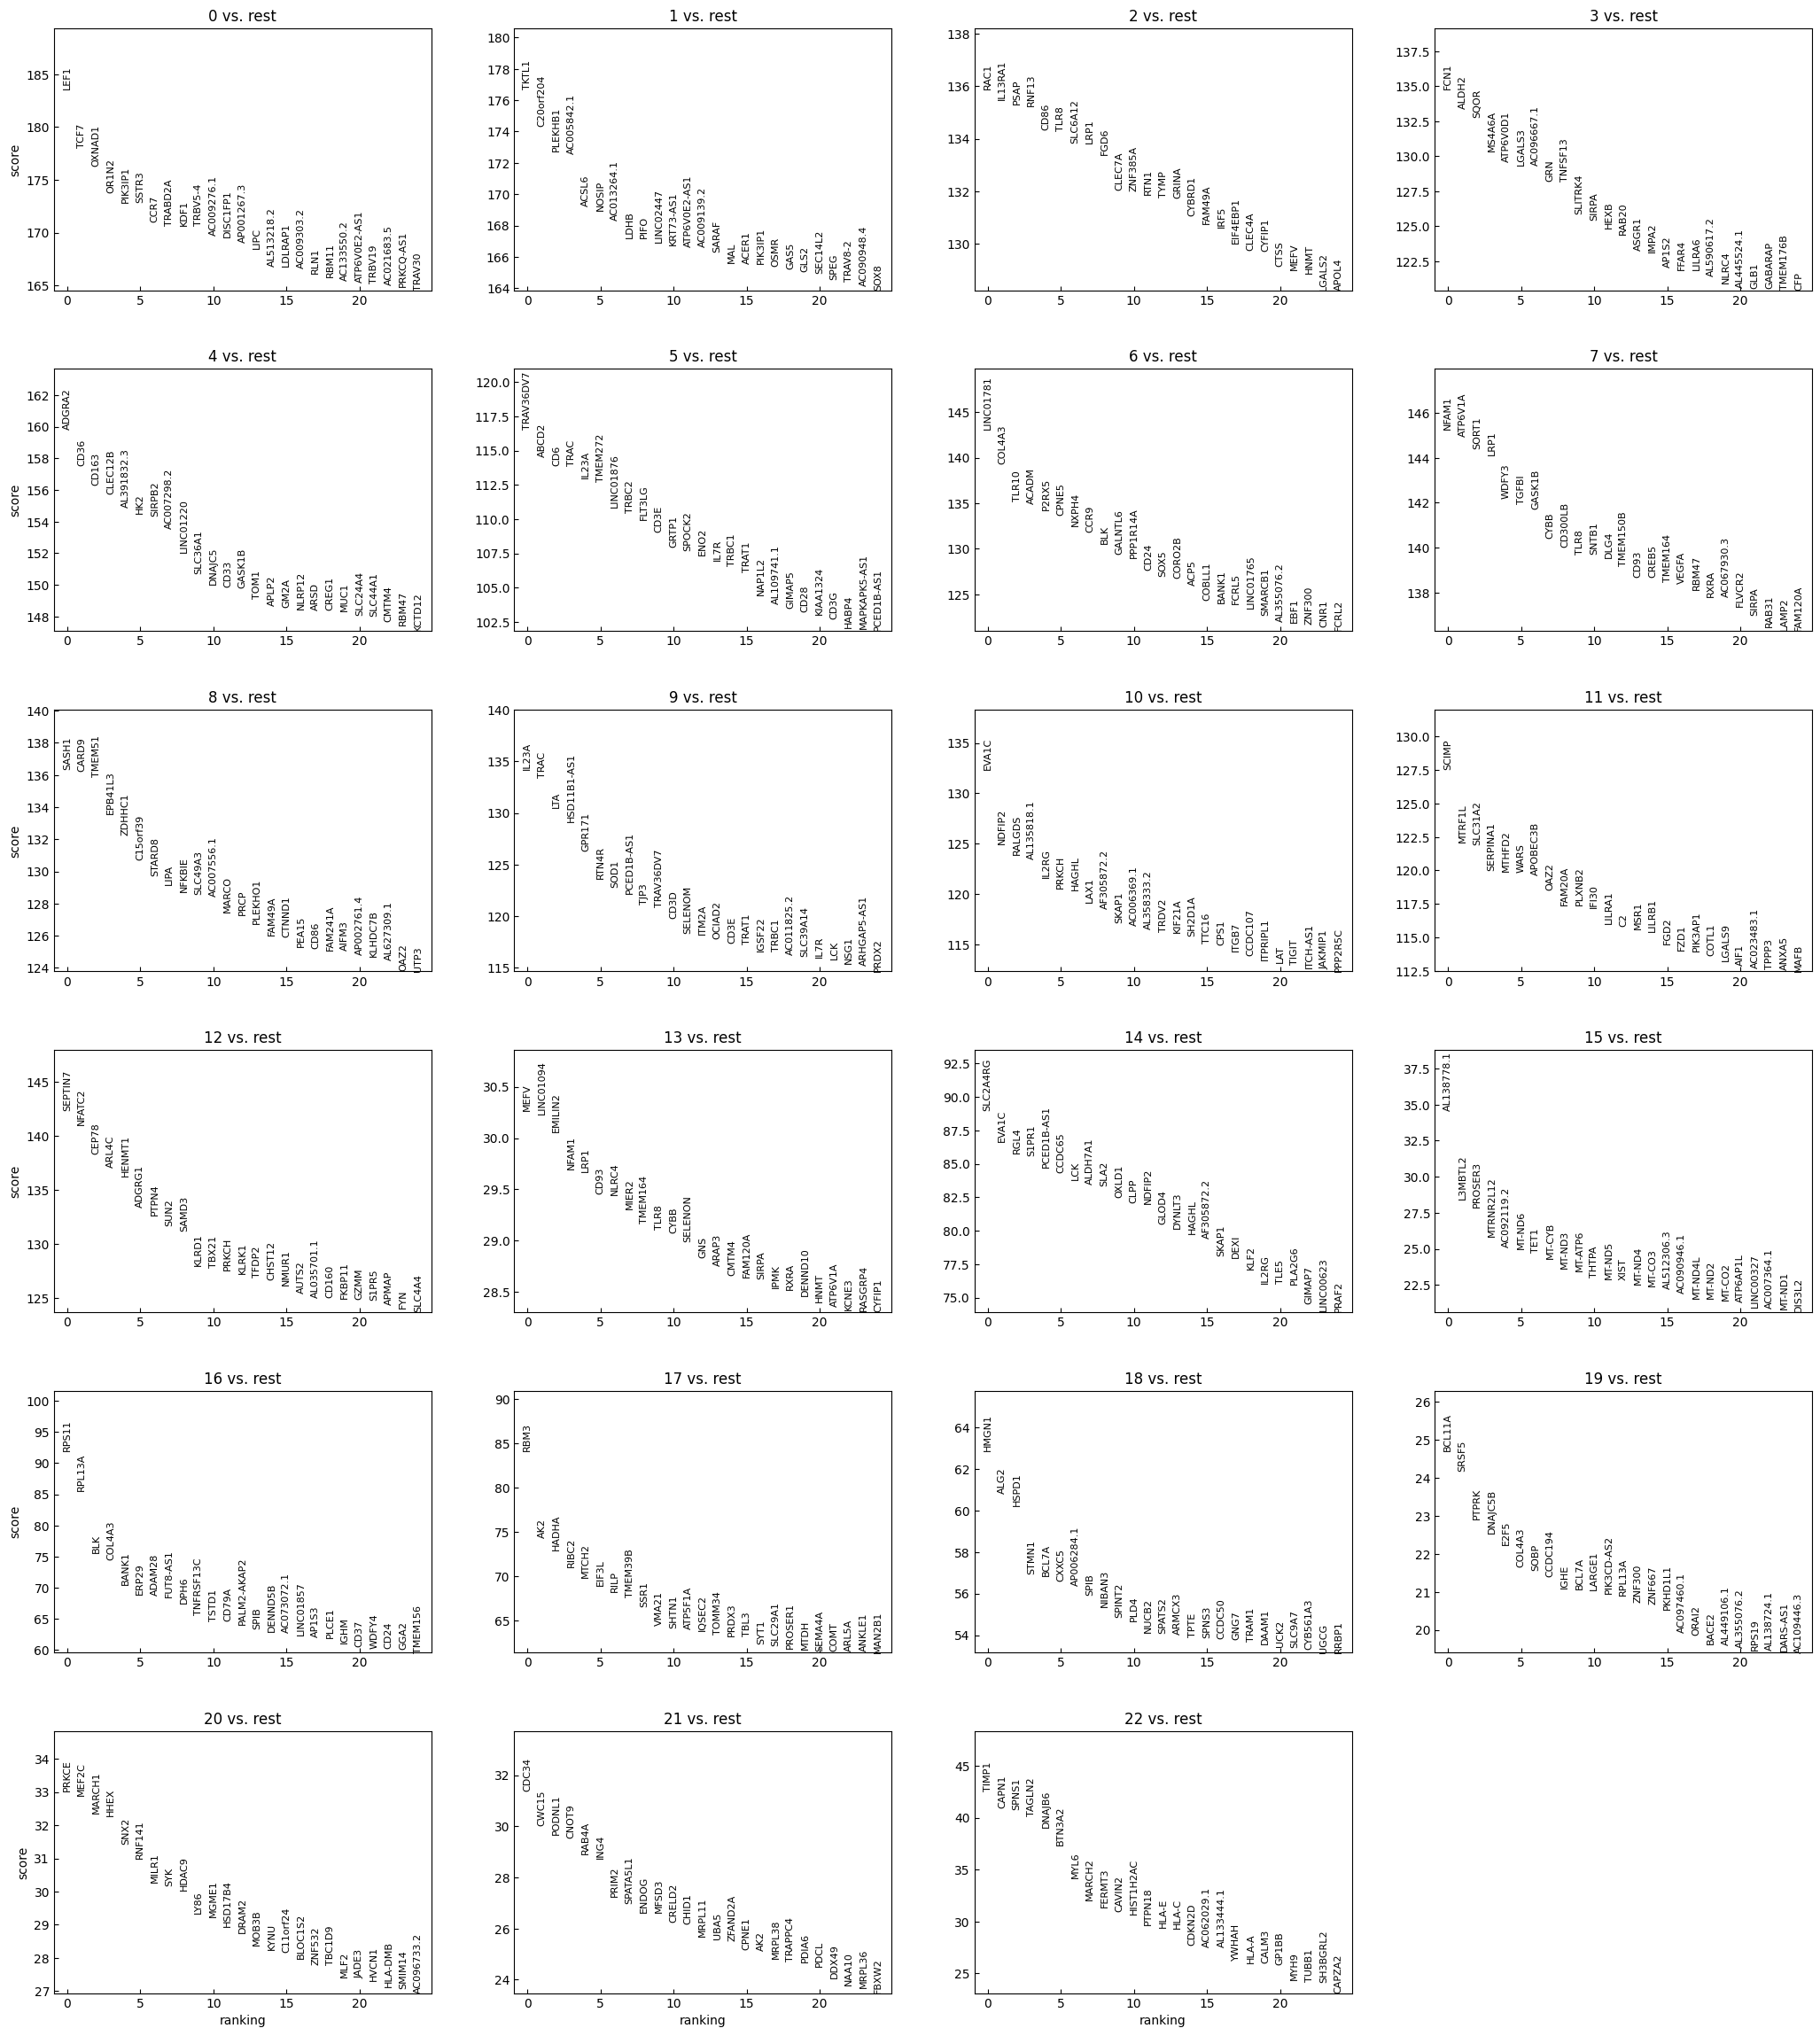

In [ ]:
sc.tl.rank_genes_groups(adata_ess, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_ess, n_genes=25, sharey=False)

In [ ]:
adata_ess.uns["marker_genes"] = list(adata_ess.uns['rank_genes_groups']['names'][0]) # The top marker genes for each cluster

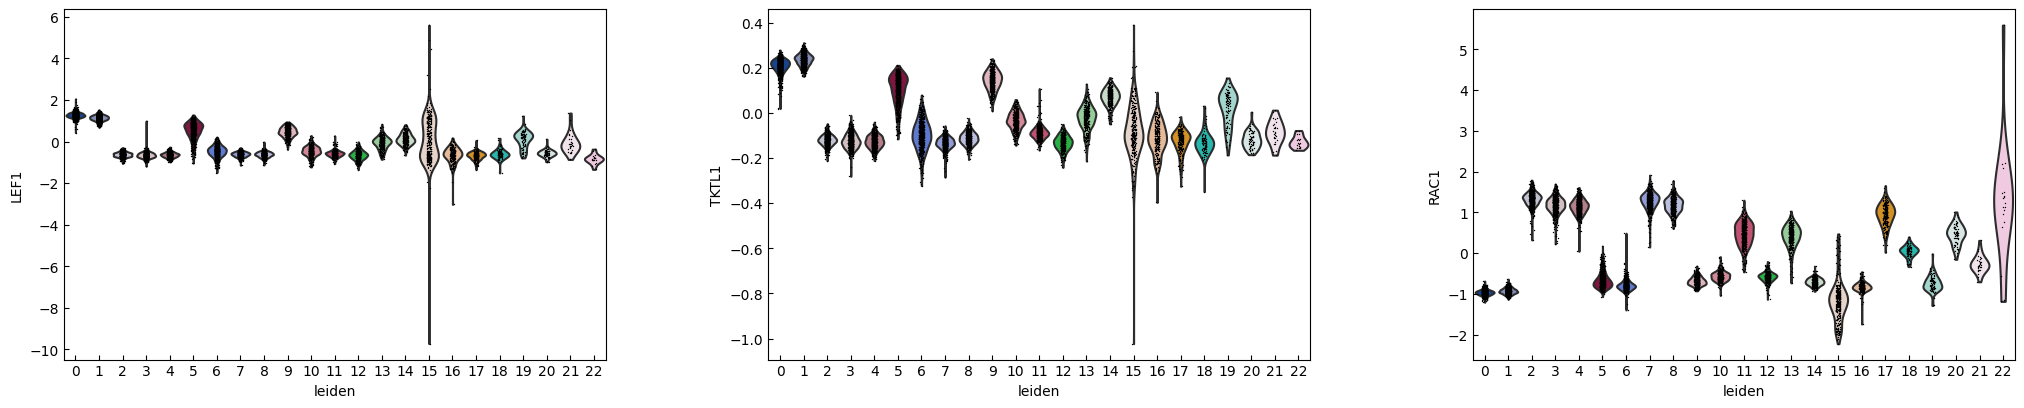

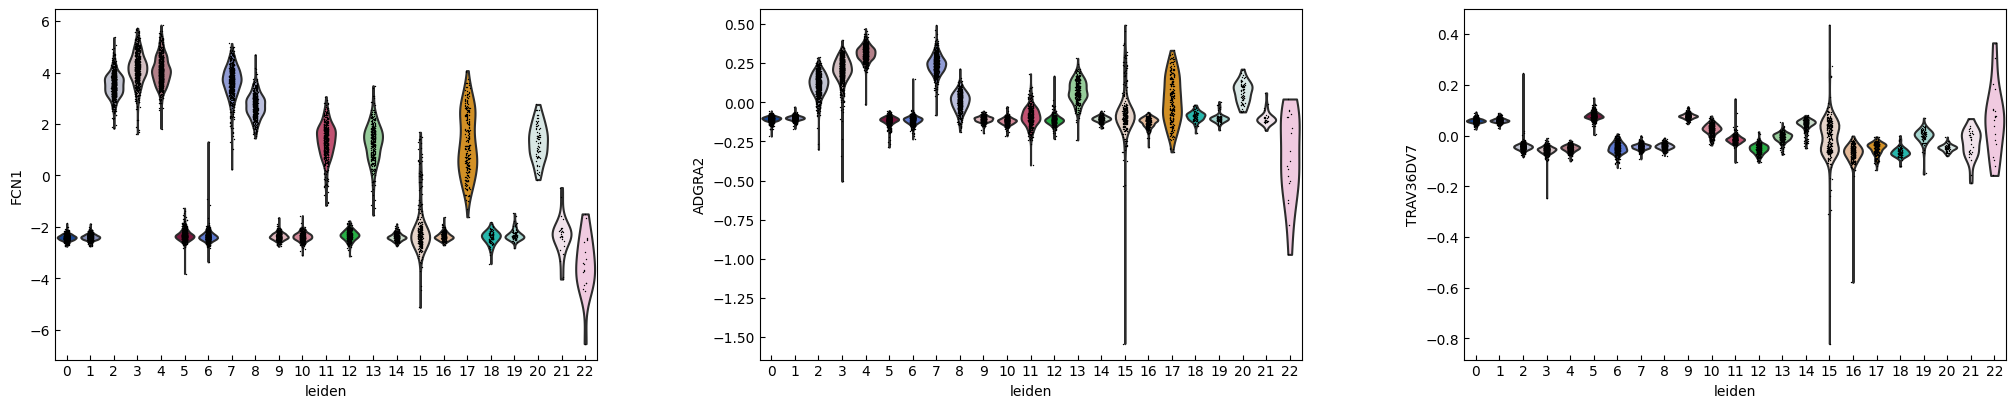

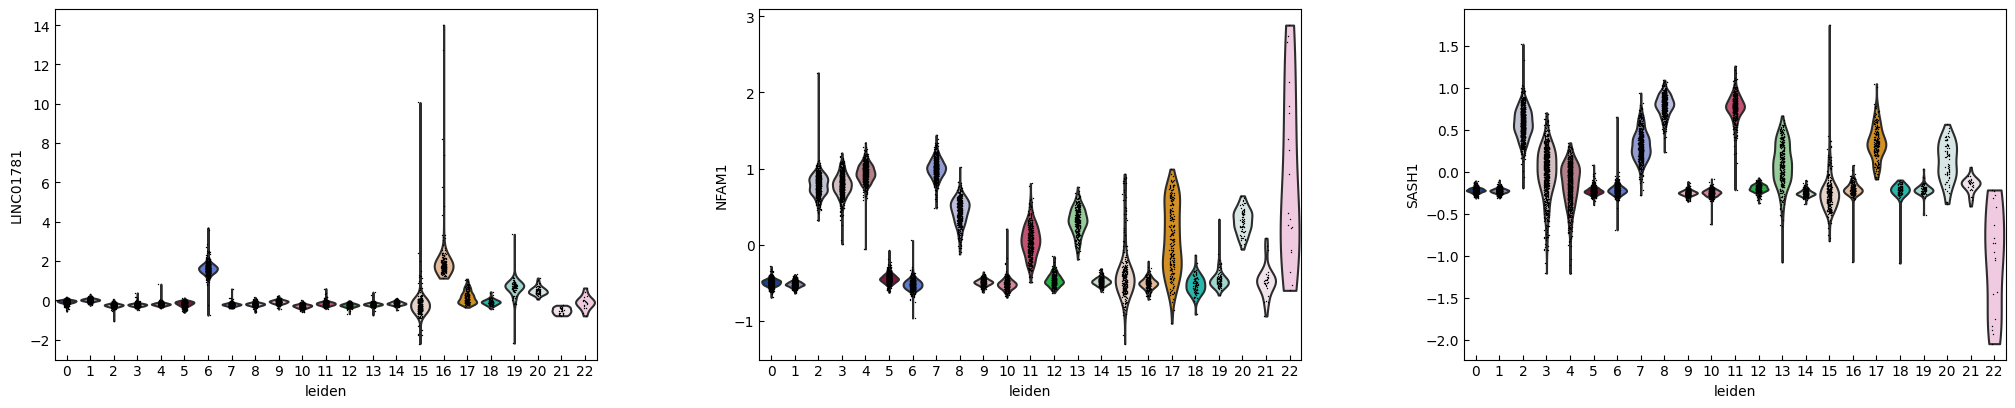

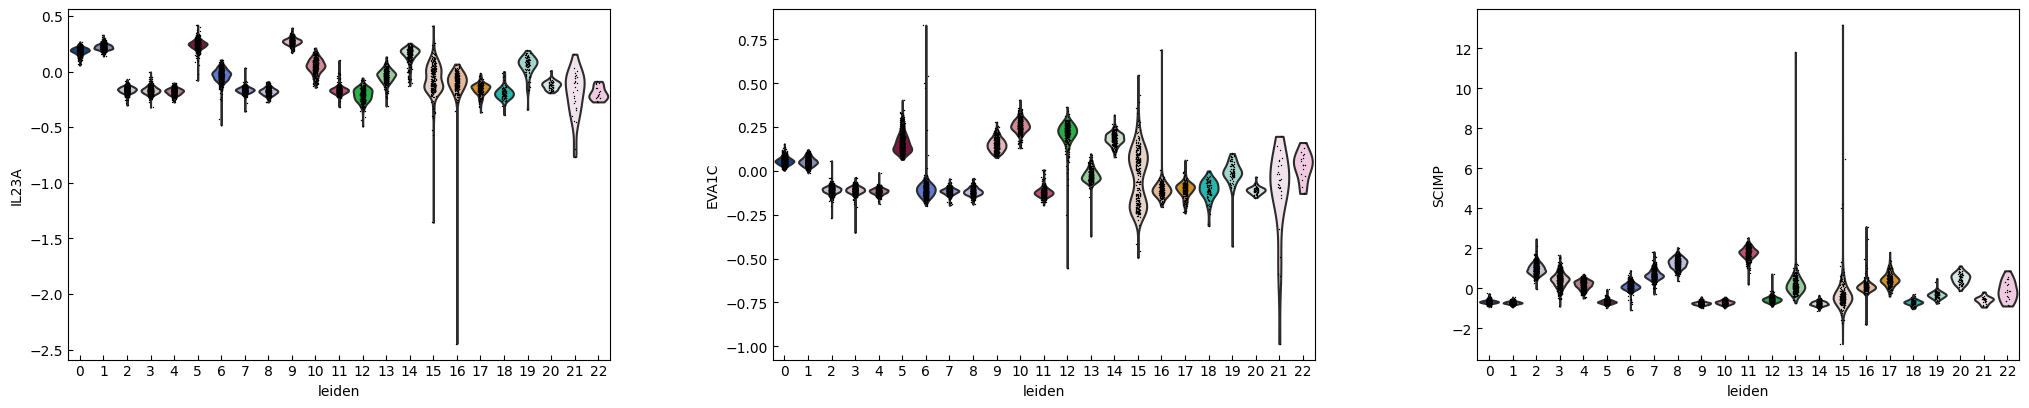

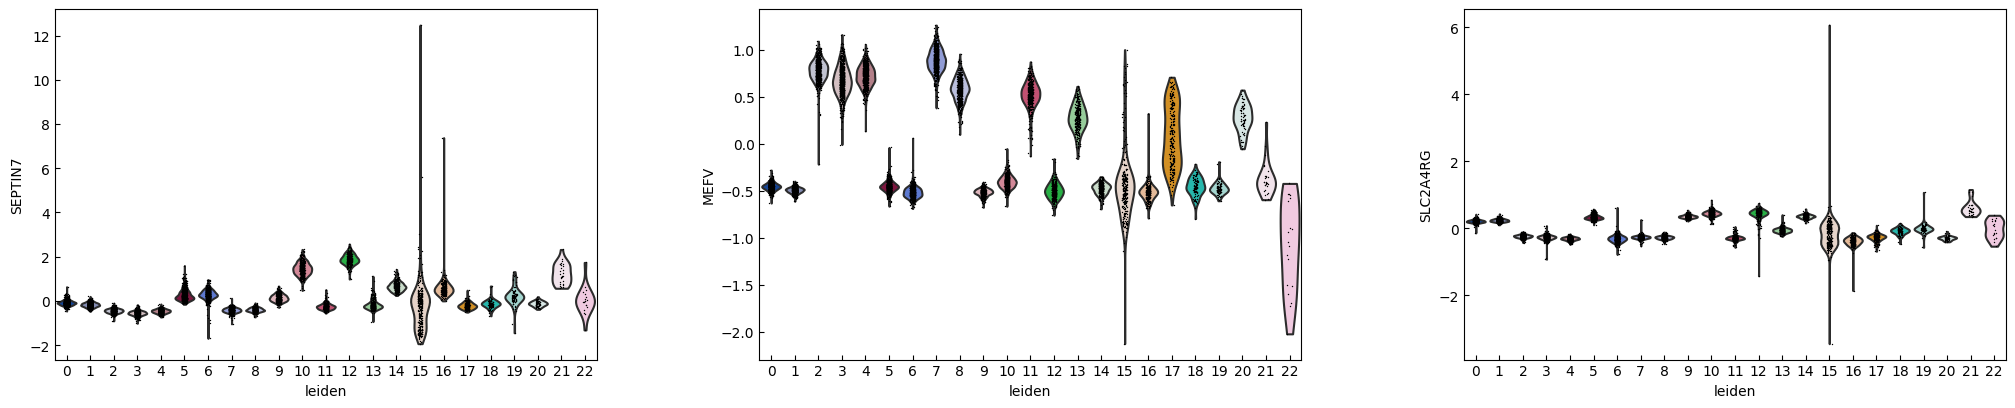

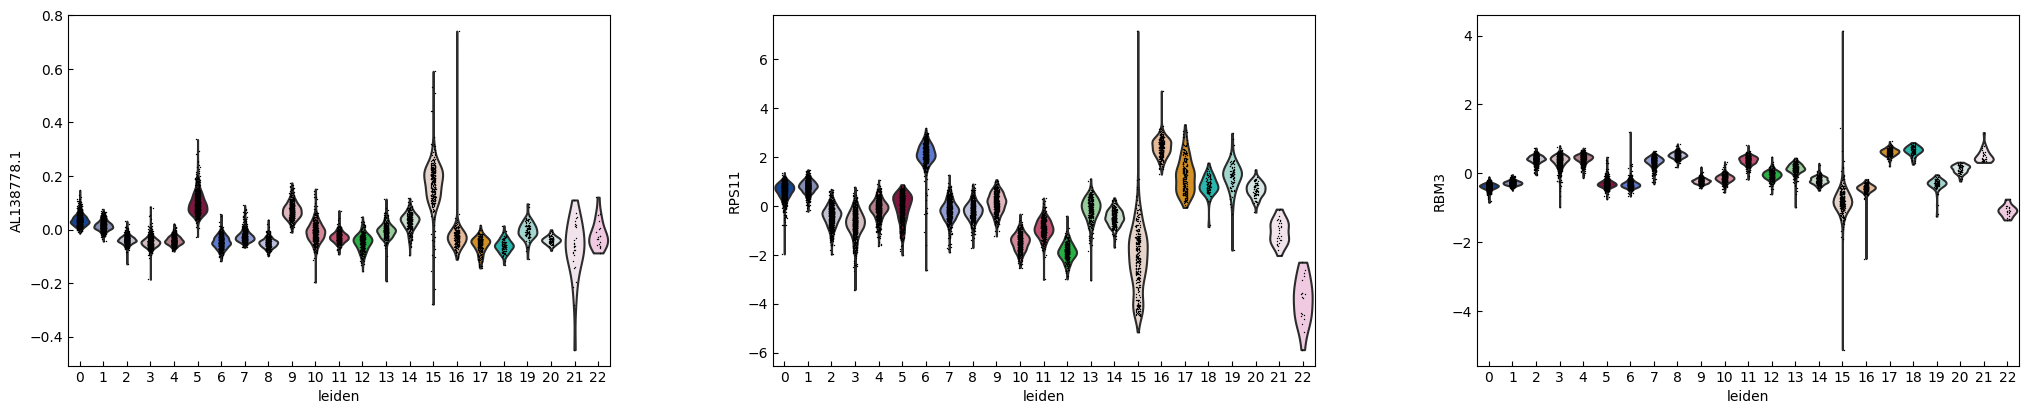

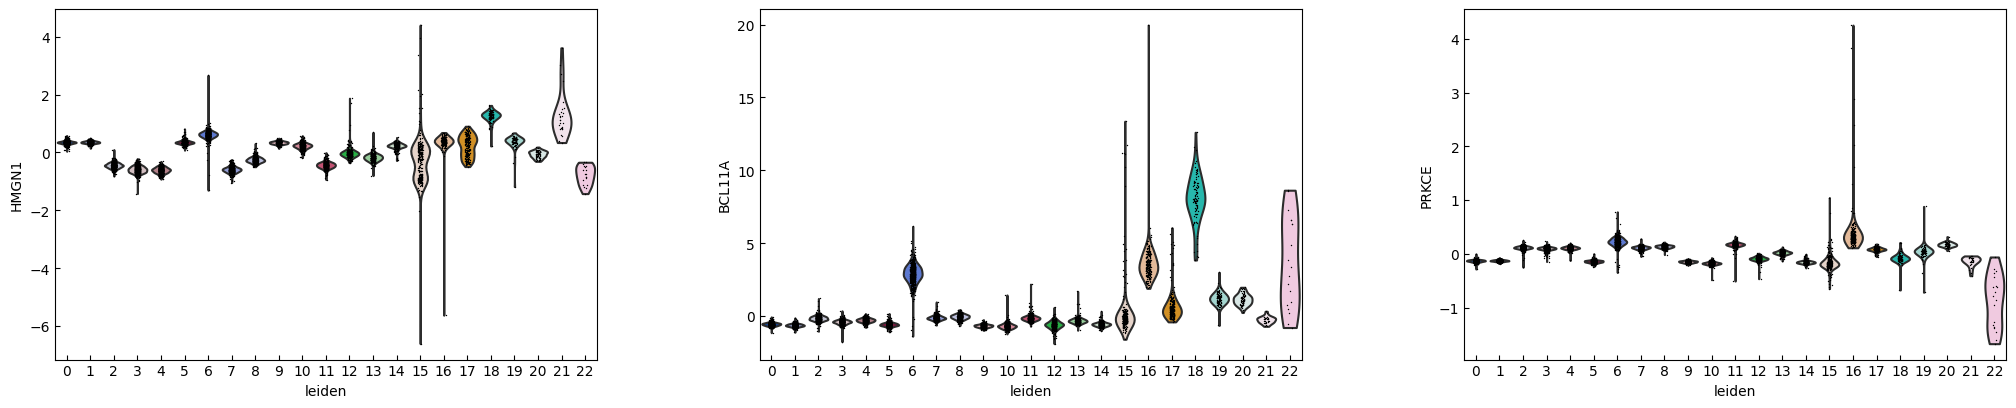

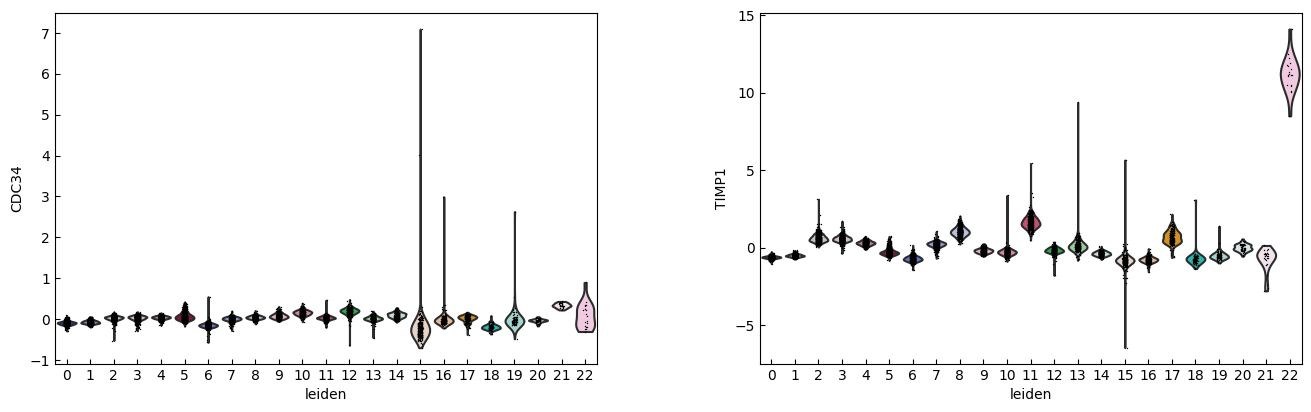

In [ ]:
adata_ess.var_names_make_unique()
n_cols = 3
for i in range(0, len(marker_genes),n_cols):
    sc.pl.violin(adata_ess, adata_ess.uns["marker_genes"][i:i+n_cols], groupby='leiden')

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


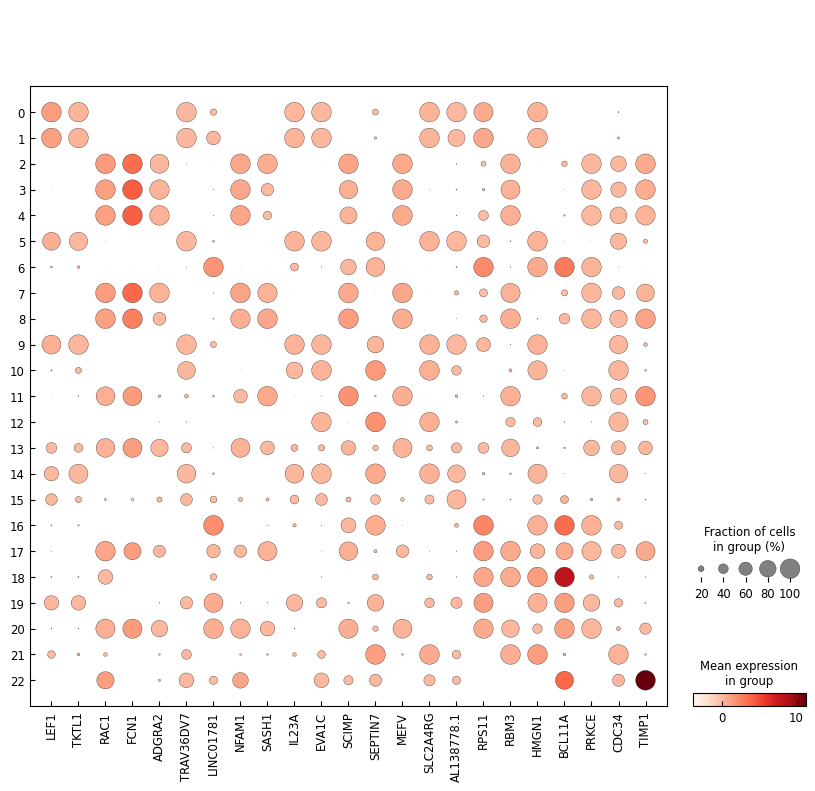

In [ ]:
sc.pl.dotplot(adata_ess, adata_ess.uns["marker_genes"], groupby='leiden',expression_cutoff=0)

In [ ]:
cluster_nmbr = 29
for i in range(25):
    print(adata_ess.uns["rank_genes_groups"]["names"][i][cluster_nmbr])

IndexError: invalid index (29)

In [ ]:
import pandas as pd
clusters = adata.obs['leiden']
cluster_set = np.unique(clusters)
adata.uns["cluster_center"] = pd.DataFrame([np.mean(adata.X[clusters==c_],axis=0) for c_ in cluster_set],columns=adata.var.index,index=cluster_set)

clusters = adata_ess.obs['leiden_ess']
cluster_set = np.unique(clusters)
adata_ess.uns["cluster_center"] = pd.DataFrame([np.mean(adata.X[clusters==c_],axis=0) for c_ in cluster_set],columns=adata.var.index,index=cluster_set)

In [ ]:
pd_ = pd.concat([adata.uns["cluster_center"],adata_ess.uns["cluster_center"]])
pd_corr = pd_.T.corr()

In [ ]:
import seaborn as sns
sns.clustermap(pd_corr[:adata.uns["cluster_center"].shape[0]].T[adata.uns["cluster_center"].shape[0]:].T,cmap="jet",vmin=0.7,figsize=(8,8))


In [ ]:
import matplotlib.pyplot as plt


size_factor = 1e4
alpha = 0.8
ps = 5
n_col_genes = 2
fontsize_label = 14
plot_data = [np.log(size_factor*adata.layers['Raw'].T/np.sum(adata.layers['Raw'],axis=1)+1).T,adata.X]
names = ['Original','RECODE']
color = np.array(adata.obs['leiden'].values,dtype=int)

n_plot = len(names)
n_ax =  n_plot * n_col_genes
for k in range(0, len(marker_genes),n_cols):
    fig,ax = plt.subplots(1,n_ax,figsize=(5*n_ax,5),tight_layout=True)
    for i in range(n_plot):
        for j in range(n_col_genes):
            i_ax = n_plot*j+i
            g1_,g2_ = marker_genes[k+j],marker_genes[k+j+1]
            ax[i_ax].scatter(plot_data[i][:,adata.var.index==g1_], plot_data[i][:,adata.var.index==g2_], c=color, alpha=alpha,zorder=10,s=ps,cmap='tab20')
            ax[i_ax].set_xlabel(g1_,fontsize=fontsize_label)
            ax[i_ax].set_ylabel(g2_,fontsize=fontsize_label)
            ax[i_ax].set_title(names[i])
            ax[i_ax].grid(ls='--',color='gray',zorder=0)



In [ ]:
adata.shape,adata.uns["RECODE_essential"].shape